# Simulator runner

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [2]:
from utilitysimv3 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [3]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/20200118_1252/meta/profiles'
INFERENCE_MAX_DEFAULT = 0.25

In [4]:
def read_profiles(profile_dir, city_name):
    profile_path = os.path.join(profile_dir, "{}.json".format(city_name))
    with open(profile_path) as f:
        data = json.load(f)
    assert "taskwise_train_profiles" in data
    assert "taskwise_infer_profiles" in data
    return data

In [5]:
city_name = "zurich"
data = read_profiles(PROFILE_DIR, city_name)
TASKS = data["taskwise_train_profiles"].keys()

# Format = [Acc, res_time, 0]
train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}

# TODO: Picking min profile, which else can we pick?
infer_profiles = {TASK_ID: min([acc for hp_id, acc in data["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

In [6]:
def create_cameras(city_names, profile_dir = PROFILE_DIR, inference_max_resources = INFERENCE_MAX_DEFAULT):
    cameras = []
    for city in city_names:        
        data = read_profiles(profile_dir, city)
        TASKS = data["taskwise_train_profiles"].keys()
        # Format = [Acc, res_time, 0]
        train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}
        # TODO: Picking min profile, which else can we pick?
        infer_start_accs = {TASK_ID: min([acc for hp_id, acc in data["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

        cameras.append(Camera(str(city),
                              train_profiles,
                              infer_start_accs,
                              inference_max_resources=inference_max_resources
                             ))
    return cameras

In [7]:
train_profiles

{'1': [[0.75, 1.5987954139709473, 0],
  [0.75, 3.199784755706787, 0],
  [0.75, 4.8036112785339355, 0],
  [0.6666666666666666, 16.4833345413208, 0],
  [0.6666666666666666, 32.723166942596436, 0],
  [0.6666666666666666, 49.00009608268738, 0],
  [0.7261904761904762, 62.6604688167572, 0],
  [0.6785714285714285, 125.45498752593994, 0],
  [0.7261904761904762, 188.3696253299713, 0],
  [0.7261904761904762, 15.838493824005127, 0],
  [0.7261904761904762, 31.668952465057373, 0],
  [0.7261904761904762, 47.51109838485718, 0],
  [0.6666666666666666, 24.341832399368286, 0],
  [0.6666666666666666, 48.66534996032715, 0],
  [0.6666666666666666, 72.41226506233215, 0],
  [0.7142857142857142, 40.224554777145386, 0],
  [0.7142857142857142, 80.45978116989136, 0],
  [0.6785714285714285, 120.65251660346985, 0],
  [0.7142857142857142, 0.8679471015930176, 0],
  [0.6666666666666666, 1.73392653465271, 0],
  [0.6666666666666666, 2.599212646484375, 0],
  [0.7142857142857142, 4.042851686477661, 0],
  [0.7142857142857

In [8]:
x=create_cameras(["zurich", "aachen", "stuttgart"])

In [9]:
cfgs=x[0].generate_training_configurations("1")

In [10]:
cfgs[6].get_completion_accuracy()

0.7261904761904762

## Run comparison

In [11]:
data = []
allocation = defaultdict(dict)
periods_to_test = [100]#, 200, 400]
provisioned_res_to_test = [16,32,64]#[1,2,4,8,16]#list(np.arange(0,1,0.05))#
camera_names = ["zurich", "aachen", "stuttgart", "darmstadt", "dusseldorf", "tubingen", "bremen", "ulm", "cologne", "jena"]*2
task_ids = [str(x) for x in range(1,6)]
INFER_MAX_RES = 0.25

schedulers_to_test = [(fair_dumb_scheduler, 'fair_dumb'),
                      (fair_naive_scheduler, 'fair_naive'),
                     (fair_sco_scheduler, 'fair_sco'),
                     (lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=3,steal_increment=INFER_MAX_RES/3), 'thief'),
                     (inference_only_scheduler, 'inference_only')
                     ]

column_names = ['period', 'resources', *[sched_name for _, sched_name in schedulers_to_test]]
for retraining_period in periods_to_test:
    for provisioned_res in provisioned_res_to_test:
        this_config_result = [retraining_period, provisioned_res]
        print("Resources: {}".format(provisioned_res))
        print("Period: {}".format(retraining_period))
        for scheduler, sched_name in schedulers_to_test:
            cameras = create_cameras(camera_names, inference_max_resources = INFER_MAX_RES)
            mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period, task_ids = task_ids)
            results, period_allocation_log = mps.step_till_completion()
            this_config_result.append(results['meta']['overall_inf_mean_auc'])
            allocation["{}_{}_{}".format(retraining_period, provisioned_res, sched_name)] = period_allocation_log
        data.append(this_config_result)
        
#         df = pd.DataFrame(data, columns=column_names)
#         df.to_pickle('temp2.pdpickle')

Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Jo

Resources: 16
Period: 100
Running task 1


Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
50
Job ulm_train_0 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Jo

Job aachen_train_11 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job bremen_train_9 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job bremen_train_9 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job dusseldorf_train_1 is done.
Job cologne_train_5 is done.
Job ulm_train_0 is done.
Job bremen_train_9 is done.
Job tubingen_train_16 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job bremen_train_9 is done.
Job tubingen_train_16 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is

Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darms

Running task 2


Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job aachen_train_3 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job tubingen

Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt

Running task 3


Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job stuttgart_train_10 is done.
Job cologne_train_0 is done.
Job stuttgart_train_10 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job

Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
J

Running task 4


Job ulm_train_0 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job jena_train_11 is done.
100
Job zurich_train_10 is done.
Job ulm_train_0 is done.
Job jena_train_11 is done.
Simulator steps done.
Job jena_train_0 is done.
Job jena_train_0 is done.
Job jena_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_

Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.


Running task 5


Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
100
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Simulator steps done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0

Job zurich_train_0 is done.
Job jena_train_9 is done.
Job darmstadt_train_4 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job darmstadt_train_4 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job darmstadt_train_4 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.


Running task 1


Job darmstadt_train_4 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job darmstadt_train_4 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job darmstadt_train_4 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job darmstadt_train_4 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job darmstadt_train_4 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job darmstadt_train_4 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job je

Job zurich_train_0 is done.
Job cologne_train_5 is done.
Job aachen_train_11 is done.
Simulator steps done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job zurich_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_tra

Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job zurich_train_3 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job zurich_train_3 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job zurich_train_3 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job zurich_train_3 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job zurich_train_3 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job zurich_train_3 is done.
Job darmstadt_train_5 is done.
Job aachen

Running task 2


Job jena_train_4 is done.
Job zurich_train_3 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job zurich_train_3 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job zurich_train_3 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job zurich_train_3 is done.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0

Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job aachen_train_26 is done.
Job dusseldorf_train_1 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job aachen_train_26 is done.
Job dusseldorf_train_1 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job aachen_train_26 is done.
Job dusseldorf_train_1 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job aachen_train_26 is done.
Job dusseldorf_train_1 is done.
Job breme

Job tubingen_train_16 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job aachen_train_26 is done.
Job dusseldorf_train_1 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job aachen_train_26 is done.
Job dusseldorf_train_1 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job aachen_train_26 is done.
Job dusseldorf_train_1 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Job jena_train_9 is done.
Job

Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job aachen_train_26 is done.
Job dusseldorf_train_1 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
100
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job aachen_train_26 is done.
Job dusseldorf_train_1 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_25 is done.
Simulator steps done.


Running task 2


Job jena_train_24 is done.
Job jena_train_24 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job d

Job dusseldorf_train_0 is done.
Job bremen_train_3 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_3 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_3 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_3 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_3 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is d

Job jena_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job cologne_train_15 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_3 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job stuttgart_train_9 is done.
100
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job cologne_train_15 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_3 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job stuttgart_train_9 is done.
Simulator steps done.


Running task 3


Job darmstadt_train_0 is done.
Job darmstadt_train_0 is done.
Job darmstadt_train_0 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.


Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job tubingen_train_15 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job tubingen_train_15 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job tubingen_train_15 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job tubingen_train_15 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job bremen_train_9 is done.
Job colog

Job ulm_train_9 is done.
Job jena_train_9 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job tubingen_train_15 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job tubingen_train_15 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job tubingen_train_15 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.

Running task 4


Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job

Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job zurich_train_10 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job darmstadt_train_9 is done.
Job cologne_train_31 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job zurich_train_10 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job darmstadt_train_9 is done.
Job cologne_train_31 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job zurich_train_10 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job darmstadt_train_9 is done.
Job cologne_train_31 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job zurich_train_10 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job darmstadt_tra

Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job darmstadt_train_9 is done.
Job cologne_train_31 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job zurich_train_10 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job darmstadt_train_9 is done.
Job cologne_train_31 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job zurich_train_10 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job darmstadt_train_9 is done.
Job cologne_train_31 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job zurich_train_10 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job darmstadt_train_9 is done.
Job cologne_train_31 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_tra

Running task 5


Job ulm_train_19 is done.
Job ulm_train_19 is done.
Job jena_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_19 is done.
Job jena_train_0 is done.
Job ulm_train_19 is done.
Job jena_train_0 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_19 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_19 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_19 is done.
Job jena_train_0 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job bremen_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job bremen_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job bremen_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0

Job jena_train_0 is done.
Job zurich_train_9 is done.
Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job aachen_train_27 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job zurich_train_9 is done.
Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job aachen_train_27 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job zurich_train_9 is done.
Job darmstadt_train_5 is done.
50
Job bremen_train_24 is done.
Job aachen_train_27 is done.
Job zurich_train_9 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job stuttgart_train_9 is done.
Job bremen_train_24 is done.
Job aachen_train_27 is done.
Job zurich_train_9 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseld

Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job stuttgart_train_9 is done.
Job bremen_train_24 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job zurich_train_9 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job stuttgart_train_9 is done.
Job bremen_train_24 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job zurich_train_9 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job stuttgart_train_9 is done.
Job bremen_train_24 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job zurich_train_9 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job st

Running task 1
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e3c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667db438>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667e29b0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e6d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_0
Best config for aachen_inference: aachen_train_0
Best config for stuttgart_inference: stuttgart_train_0
Best config for darmstadt_inference: darmstadt_train_27
Best config for dusseldorf_inference: dusseldorf_train_24
Best config for tubingen_inference: tubingen_train_18
Best config for bremen_inference: bremen_train_20
Best config for ulm_inference: ulm_train_18
Best config for cologne_inference: cologne_train_21
Best config for jena_inference: jena_train_9
Best config for zurich_inference: zurich_train_0
Best config for aachen_inference: aachen_train_0
Best config for stuttgart_inference: stuttgart_train_0
Best config for darmstadt_inference: darmstadt_train_27
Best config for dusseldorf_inference: dusseldorf_train_24
Best config for tubingen_inference: tubingen_train_18
Best config for bremen_inference: bremen_train_20
Best config for ulm_inference: ulm_train_18
Best config for cologne_inference: cologne_train_21
Best config for jena_

Job tubingen_train_18 is done.
Job tubingen_train_18 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job jena_train_9 is done.
Job ulm_train_0 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_18 is done.
Job jena_train_9 is done.
Job ulm_train_0 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_18 is done.
Job jena_train_9 is done.
Job ulm_train_0 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_18 is done.
Job stuttgart_train_0 is done.
Job bremen_train_18 is done.
Job jena_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job zurich_train_0 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_0 i

Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmst

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.21666666666666673, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.316666666666667, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.3833333333333334, 0.30000000000000016], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.30000000000000004, 1.7999999999999998], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.3000000000000001, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.8, 0.4666666666666665], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.8, 0.13333333333333341], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.8, 0.3833333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.8, 2.433333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.8, 4.966666666666666], <utilitysimv3.InferenceJob object at 0x7f3e6695e3c8>: [0.21666666666666673, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e667db438>: [

Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.


Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_18 is done.
Job bremen_train_18 is done.
Job aachen_train_0 is done.
Job z

Running task 2
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e3c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667db438>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667e29b0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e6d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_2
Best config for aachen_inference: aachen_train_35
Best config for stuttgart_inference: stuttgart_train_34
Best config for darmstadt_inference: darmstadt_train_0
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_1
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_11
Best config for cologne_inference: cologne_train_22
Best config for jena_inference: jena_train_33
Best config for zurich_inference: zurich_train_2
Best config for aachen_inference: aachen_train_35
Best config for stuttgart_inference: stuttgart_train_34
Best config for darmstadt_inference: darmstadt_train_0
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_1
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_11
Best config for cologne_inference: cologne_train_22
Best config for jena_inf

Job jena_train_33 is done.
Job jena_train_33 is done.
Job bremen_train_0 is done.
Job bremen_train_0 is done.
Job jena_train_33 is done.
Job bremen_train_0 is done.
Job jena_train_33 is done.
Job tubingen_train_3 is done.
Job bremen_train_0 is done.
Job jena_train_33 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_0 is done.
Job jena_train_33 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_34 is done.
Job dusseldorf_train_0 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job bremen_train_0 is done.
Job aachen_train_35 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job jena_train_33 is done.
Job st

Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_22 is done.
Job ulm_train_11 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_22 is done.
Job ulm_train_11 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_22 is done.
Job ulm_train_11 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job 

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.13333333333333347, 0.7166666666666666], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.21666666666666679, 1.0500000000000003], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.21666666666666679, 0.8833333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.21666666666666679, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.30000000000000004, 0.4666666666666668], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.2166666666666667, 4.133333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.3000000000000001, 2.1], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.21666666666666673, 1.35], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.3000000000000001, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.3000000000000001, 2.8833333333333333], <utilitysimv3.InferenceJob object at 0x7f3e6695e3c8>: [0.133333333333333

Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_22 is done.
Job ulm_train_11 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_22 is done.
Job ulm_train_11 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_22 is done.
Job ulm_train_11 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job 

Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_22 is done.
Job ulm_train_11 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_22 is done.
Job ulm_train_11 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_22 is done.
Job ulm_train_11 is done.
Job jena_train_33 is done.
Job stuttgart_train_34 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job bremen_train_0 is done.
Job darmstadt_train_1 is done.
Job 

Running task 3
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e3c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667db438>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667e29b0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e6d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_19
Best config for aachen_inference: aachen_train_2
Best config for stuttgart_inference: stuttgart_train_0
Best config for darmstadt_inference: darmstadt_train_0
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_2
Best config for bremen_inference: bremen_train_20
Best config for ulm_inference: ulm_train_9
Best config for cologne_inference: cologne_train_0
Best config for jena_inference: jena_train_34
Iter 1, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.3833333333333334, 0.7166666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.30000000000000004, 0.466666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.3833333333333334, 0.5499999999999999], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.8, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e669922

Job darmstadt_train_0 is done.
Job darmstadt_train_0 is done.
Job zurich_train_19 is done.
Job cologne_train_0 is done.
Job jena_train_34 is done.
Job jena_train_34 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job jena_train_34 is done.
Job darmstadt_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job jena_train_34 is done.
Job stuttgart_train_0 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubi

Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_tr

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.3833333333333334, 0.7166666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.30000000000000004, 0.466666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.3833333333333334, 0.5499999999999999], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.8, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.8, 1.3], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.8, 1.1333333333333333], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.8, 2.0166666666666666], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.8, 1.2166666666666668], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.8, 1.1333333333333333], <utilitysimv3.InferenceJob object at 0x7f3e6695e3c8>: [0.3833333333333334, 0.7166666666666667], <utilitysimv3.InferenceJob object at 0x7f3e667db438>: [0.300000000000000

Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubi

Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_34 is done.
Job bremen_train_20 is done.
Job ulm_train_9 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job duss

Running task 4
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e3c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667db438>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667e29b0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e6d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_31
Best config for aachen_inference: aachen_train_34
Best config for stuttgart_inference: stuttgart_train_19
Best config for darmstadt_inference: darmstadt_train_9
Best config for dusseldorf_inference: dusseldorf_train_18
Best config for tubingen_inference: tubingen_train_0
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_0
Best config for cologne_inference: cologne_train_2
Best config for jena_inference: jena_train_18
Best config for zurich_inference: zurich_train_31
Best config for aachen_inference: aachen_train_34
Best config for stuttgart_inference: stuttgart_train_19
Best config for darmstadt_inference: darmstadt_train_9
Best config for dusseldorf_inference: dusseldorf_train_18
Best config for tubingen_inference: tubingen_train_0
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_0
Best config for cologne_inference: cologne_train_2
Best config for jena_inf

Job ulm_train_0 is done.
Job jena_train_18 is done.
Job jena_train_18 is done.
Job ulm_train_0 is done.
Job jena_train_18 is done.
Job ulm_train_0 is done.
Job jena_train_18 is done.
Job ulm_train_0 is done.
Job jena_train_18 is done.
Job ulm_train_0 is done.
Job cologne_train_2 is done.
Job jena_train_18 is done.
Job ulm_train_0 is done.
Job cologne_train_2 is done.
Job darmstadt_train_9 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job stuttgart_train_19 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job stuttgart_train_19 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job stuttgart_train_19 is done.
Job tubingen_train_9 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 i

Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job 

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.21666666666666673, 1.9333333333333325], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.3, 0.7999999999999998], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.3000000000000001, 0.4833333333333338], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.21666666666666673, 2.716666666666666], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.30000000000000004, 0.0833333333333333], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.3000000000000001, 1.8833333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.3833333333333334, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.30000000000000004, 1.7500000000000002], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.30000000000000004, 2.216666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.3833333333333334, 1.1333333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66

Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
50
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.


Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_2 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_0 is done.
Job jena_train_18 is done.
Job 

Running task 5
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e3c8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667db438>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e667e29b0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e6695e6d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_0
Best config for aachen_inference: aachen_train_3
Best config for stuttgart_inference: stuttgart_train_24
Best config for darmstadt_inference: darmstadt_train_2
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_27
Best config for bremen_inference: bremen_train_24
Best config for ulm_inference: ulm_train_19
Best config for cologne_inference: cologne_train_1
Best config for jena_inference: jena_train_0
Best config for zurich_inference: zurich_train_0
Best config for aachen_inference: aachen_train_3
Best config for stuttgart_inference: stuttgart_train_24
Best config for darmstadt_inference: darmstadt_train_2
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_27
Best config for bremen_inference: bremen_train_24
Best config for ulm_inference: ulm_train_19
Best config for cologne_inference: cologne_train_1
Best config for jena_infe

Job darmstadt_train_2 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job jena_train_0 is done.
Job bremen_train_24 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job zurich_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_18 is done.
Job tubingen_train_27 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 

Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job stuttgart_train_24 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job stuttgart_train_24 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job aachen_train_3 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job aachen_train_3 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job stuttgart_train_24 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job 

Best config for jena_inference: jena_train_0
Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669763c8>: [0.21666666666666673, 0.04999999999999988], <utilitysimv3.InferenceJob object at 0x7f3e66aa1978>: [0.30000000000000004, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e66992b00>: [0.26666666666666683, 0.05000000000000031], <utilitysimv3.InferenceJob object at 0x7f3e66b688d0>: [0.3000000000000001, 5.716666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66aa18d0>: [0.3833333333333334, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e669922e8>: [0.30000000000000004, 0.8833333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66967048>: [0.3833333333333334, 1.6333333333333333], <utilitysimv3.InferenceJob object at 0x7f3e6695eb38>: [0.3833333333333334, 0.0], <utilitysimv3.InferenceJob object at 0x7f3e66aa1da0>: [0.26666666666666683, 2.3500000000000005], <utilitysimv3.InferenceJob object at 0x7f3e66b68278>: [0.30000000000000004, 2.216666666666667], <utilitysimv

Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job aachen_train_3 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job stuttgart_train_24 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job aachen_train_3 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job stuttgart_train_24 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
50
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job aachen_train_3 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job stuttgart_train_24 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job aachen_train_3 is done.
Job 

Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job aachen_train_3 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job stuttgart_train_24 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job aachen_train_3 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job stuttgart_train_24 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job aachen_train_3 is done.
Job tubingen_train_27 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job stuttgart_train_24 is done.
Job dusseldorf_train_18 is done.
Job jena_train_0 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job aachen_train_3 is done.
Job tub

Running task 1
Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
Running task 5
Resources: 32
Period: 100
Running task 1

Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job jena_train_9 is done.
Job jena_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job jena_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job jena_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job 

Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is

Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 i

Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job aachen_train_11 is done.
Job ulm_train_0 is done.
Job cologne_train_5 is done.
Job tubingen_train_16 is do

Job ulm_train_7 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_11 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Jo

Running task 2


Job cologne_train_11 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_11 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_11 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_11 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_t

Job stuttgart_train_11 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_11 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_11 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_11 is done.
Job ulm_train_7 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job darmstadt_train_5 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_11 is done.
Job

Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is 

Running task 3


Job bremen_train_4 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job cologne_train_0 is done.
Job jena_train_7 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job cologne_train_0 is done.
Job jena_train_7 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darm

Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job cologne_train_0 is done.
Job jena_train_7 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job cologne_train_0 is done.
Job jena_train_7 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Job aachen_train_11 is done.
Job cologne_train_5 is done.
Job zurich_t

Job cologne_train_5 is done.
Job zurich_train_0 is done.
Job bremen_train_9 is done.
Job ulm_train_0 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Simulator steps done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job zurich_

Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job ulm_train_7 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job ulm_train_7 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job ulm_train_7 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job ulm

Running task 2


Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job ulm_train_7 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job ulm_train_7 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job ulm_train_7 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_4 is done.
Job darmstadt_train_5 is done.
Job zurich_train_3 is done.
Job ulm_train_7 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job aachen

Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_tr

Running task 3


Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job jena_train_7 is done.
Job stuttgart_train_10 is done.
Job bremen_train_4 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job jena_train_7 is done.
Job stuttgart_train_10 is done.
Job bremen_train_4 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job jena_train_7 is done.
Job stuttgart_train_10 is done.
Job bremen_train_4 is done.
Job tubingen_train_7 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job jena_train_7 is done.
Job stuttgart_train_10 is done.
Job bremen_train_4 is done.
Job tu

Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job jena_train_7 is done.
Job stuttgart_train_10 is done.
Job bremen_train_4 is done.
Job tubingen_train_7 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job jena_train_7 is done.
Job stuttgart_train_10 is done.
Job bremen_train_4 is done.
Job tubingen_train_7 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job jena_train_7 is done.
Job stuttgart_train_10 is done.
Job bremen_train_4 is done.
Job tubingen_train_7 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job jena_train_7 is done.
Job stuttgart_train_10 is done.
Job bremen_train_4 is done.
Jo

Running task 4


Job zurich_train_10 is done.
Job aachen_train_11 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job aachen_train_11 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job aachen_train_11 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job aachen_train_11 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job aachen_train_11 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job zurich_train_10 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job stuttgart_train_6 is done.
Job zurich_train_10 is done.
Job tubingen_train_7 i

Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 i

Running task 5


Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job darmstadt_train_5 is done.
Job tubingen_train_3 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 i

Running task 1


Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job stuttgart_train_25 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job darmstadt_train_9 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done

Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_

Job aachen_train_11 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job zurich_train_0 is done.
Job stuttgart_train_25 is done.
Job ulm_train_0 is done.
Job cologne_train_9 is done.
Job dusseldorf_train_1 is done.
Job darmstadt_train_9 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job zurich_train_0 is done.
Job stuttgart_t

Running task 2


Job jena_train_24 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job jena_train_24 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job 

Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job stuttgart_train_9 is done.
Job darmstadt_train_11 is done.
Job jena_train_24 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job stuttgart_train_9 is done.
Job darmstadt_train_11 is done.
Job jena_train_24 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job stuttgart_train_9 is done.
Job darmstadt_train_11 is done.
Job jena_train_24 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is don

Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job stuttgart_train_9 is done.
Job darmstadt_train_11 is done.
Job jena_train_24 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job stuttgart_train_9 is done.
Job darmstadt_train_11 is done.
Job jena_train_24 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job stuttgart_train_9 is done.
Job darmstadt_train_11 is done.
Job jena_train_24 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
J

Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
100
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job stuttgart_train_9 is done.
Job darmstadt_train_11 is done.
Job jena_train_24 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Simulator steps done.


Running task 3


Job darmstadt_train_0 is done.
Job darmstadt_train_0 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job cologne_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is d

Job tubingen_train_15 is done.
Job stuttgart_train_10 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job tubingen_train_15 is done.
Job stuttgart_train_10 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job tubingen_train_15 is done.
Job stuttgart_train_10 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job tubingen_train_15 is done.
Job stuttgart_train_10 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job tubingen_train_15 is done.
Job stuttgart_train_10 is done.
Job cologne_train

Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job tubingen_train_15 is done.
Job stuttgart_train_10 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job tubingen_train_15 is done.
Job stuttgart_train_10 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job tubingen_train_15 is done.
Job stuttgart_train_10 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
Job tubingen_train_15 is done.
Job stuttgart_train_10 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job ulm_train_9 is done.
J

Running task 4


Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job aachen_train

Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job cologne_train_31 is done.
Job zurich_train_10 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job cologne_train_31 is done.
Job zurich_train_10 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job cologne_train_31 is done.
Job zurich_train_10 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job cologne_train_31 is done.
Job zurich_train_10 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is d

Job zurich_train_10 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job cologne_train_31 is done.
Job zurich_train_10 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job cologne_train_31 is done.
Job zurich_train_10 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job cologne_train_31 is done.
Job zurich_train_10 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job cologne_train_31 is done.
Job zurich_train_10 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 

Running task 5


Job jena_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_27 is done.
Job aachen_train_27 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job aachen_train_27 is done.
Job ulm_train_3 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job aachen_train_27 is done.
Job jena_trai

Job dusseldorf_train_0 is done.
Job aachen_train_27 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job cologne_train_10 is done.
Job stuttgart_train_9 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_27 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job cologne_train_10 is done.
Job stuttgart_train_9 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_27 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job cologne_train_10 is done.
Job stuttgart_train_9 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_27 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job cologne_train_10 is done.
Job stuttgart_train_9 is done.
Job 

Job aachen_train_27 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job cologne_train_10 is done.
Job stuttgart_train_9 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_27 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job cologne_train_10 is done.
Job stuttgart_train_9 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_27 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job cologne_train_10 is done.
Job stuttgart_train_9 is done.
Job tubingen_train_27 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_27 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job cologne_train_10 is done.
Job stuttgart_train_9 is done.
Job tubingen_train_27 is done.
Job b

Running task 1
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bfbe0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d6a90>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e667da400>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66bcb080>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_0
Best config for aachen_inference: aachen_train_19
Best config for stuttgart_inference: stuttgart_train_0
Best config for darmstadt_inference: darmstadt_train_27
Best config for dusseldorf_inference: dusseldorf_train_24
Best config for tubingen_inference: tubingen_train_0
Best config for bremen_inference: bremen_train_20
Best config for ulm_inference: ulm_train_18
Best config for cologne_inference: cologne_train_9
Best config for jena_inference: jena_train_9
Best config for zurich_inference: zurich_train_0
Best config for aachen_inference: aachen_train_19
Best config for stuttgart_inference: stuttgart_train_0
Best config for darmstadt_inference: darmstadt_train_27
Best config for dusseldorf_inference: dusseldorf_train_24
Best config for tubingen_inference: tubingen_train_0
Best config for bremen_inference: bremen_train_20
Best config for ulm_inference: ulm_train_18
Best config for cologne_inference: cologne_train_9
Best config for jena_in

Job darmstadt_train_27 is done.
Job tubingen_train_0 is done.
Job ulm_train_18 is done.
Job ulm_train_18 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job ulm_train_18 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job ulm_train_18 is done.
Job stuttgart_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job dusseldorf_train_24 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_

Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.


Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.7666666666666668, 0.766666666666667], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.9333333333333335, 0.01666666666666683], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.3500000000000001, 0.18333333333333357], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.8500000000000001, 5.433333333333334], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [1.6, 0.10000000000000053], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [1.6, 1.5166666666666668], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [1.6, 0.016666666666666607], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [1.6, 2.6000000000000005], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [1.6, 7.266666666666667], <utilitysimv3.InferenceJob object at 0x7f3e668bfbe0>: [0.7666666666666668, 0.766666666666667], <utilitysimv3.InferenceJob

Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job

Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.


Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
100
Job zurich_train_0 is done.
Job dusseldorf_train_24 is done.
Job jena_train_9 is done.
Job tubingen_train_0 is done.
Job darmstadt_train_27 is done.
Job bremen_train_20 is done.
Job stuttgart_train_0 is done.
Job ulm_train_18 is done.
Job cologne_train_9 is done.
Simulator steps done.


Running task 2
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bfbe0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d6a90>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e667da400>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66bcb080>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_3
Best config for aachen_inference: aachen_train_35
Best config for stuttgart_inference: stuttgart_train_9
Best config for darmstadt_inference: darmstadt_train_0
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_3
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_11
Best config for cologne_inference: cologne_train_22
Best config for jena_inference: jena_train_33
Best config for zurich_inference: zurich_train_3
Best config for aachen_inference: aachen_train_35
Best config for stuttgart_inference: stuttgart_train_9
Best config for darmstadt_inference: darmstadt_train_0
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_3
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_11
Best config for cologne_inference: cologne_train_22
Best config for jena_infer

Job jena_train_33 is done.
Job jena_train_33 is done.
Job tubingen_train_3 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_33 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job jena_train_33 is done.
Job bremen_train_0 is done.
Job aachen_train_35 is done.
Job stuttgart_train_9 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job jena_train_33 is done.
Job darmstadt_train_1 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job jena_train_33 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job jena_train_33 is done.
Job darmstadt_train_1 is done.
Job

Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bre

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.2666666666666668, 0.7666666666666667], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.26666666666666683, 2.016666666666667], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.2666666666666668, 8.266666666666667], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.2666666666666668, 0.4333333333333335], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.26666666666666683, 0.10000000000000084], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [0.2666666666666667, 8.433333333333334], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [0.2666666666666668, 2.1], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [0.2666666666666668, 4.266666666666667], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [0.26666666666666683, 0.35000000000000026], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [0.26666666666666683, 2.6], <utilitysimv3.InferenceJob object at 0x7f3e668

Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zuric

Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job aachen_train_35 is done.
Job jena_train_33 is done.
Job cologne_train_22 is done.
Job bremen_train_0 is done.
Job tubingen_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job zurich_train_3 is done.
Job dusse

Running task 3
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bfbe0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d6a90>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e667da400>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66bcb080>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for aachen_inference: aachen_train_2
Best config for stuttgart_inference: stuttgart_train_27
Best config for darmstadt_inference: darmstadt_train_0
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_2
Best config for bremen_inference: bremen_train_9
Best config for ulm_inference: ulm_train_9
Best config for cologne_inference: cologne_train_0
Best config for jena_inference: jena_train_9
Iter 1, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.26666666666666683, 0.43333333333333346], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.3500000000000001, 1.4333333333333333], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.26666666666666683, 0.6000000000000001], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.3500000000000001, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.43333333333333357, 0.2666666666666665], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0

Job darmstadt_train_0 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job zurich_train_19 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_2 is done.
Job jena_train_9 is done.
Job cologne_train_0 is done.
Job stuttgart_train_0 is done.
Job dusseldorf_train_0 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job aachen_train_2 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubinge

Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_t

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.7666666666666668, 0.8499999999999999], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.2666666666666668, 1.0166666666666666], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.26666666666666683, 0.18333333333333313], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.43333333333333357, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.5166666666666668, 0.35000000000000003], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [0.7666666666666668, 5.266666666666667], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [0.43333333333333357, 3.099999999999999], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [0.43333333333333357, 4.1], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [0.7666666666666668, 3.5999999999999996], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [1.6, 5.683333333333334], <utilitysimv3.InferenceJob object at 0x7f3e668bfbe0>: [0.766

Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_trai

Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job stuttgart_train_0 is done.
Job tubingen_train_2 is done.
Job aachen_train_2 is done.
Job jena_train_9 is done.
Job dusseldorf_train_0 is done.
Job cologne_train

Running task 4
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bfbe0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d6a90>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e667da400>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66bcb080>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_10
Best config for aachen_inference: aachen_train_34
Best config for stuttgart_inference: stuttgart_train_19
Best config for darmstadt_inference: darmstadt_train_9
Best config for dusseldorf_inference: dusseldorf_train_9
Best config for tubingen_inference: tubingen_train_9
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_0
Best config for cologne_inference: cologne_train_31
Best config for jena_inference: jena_train_18
Best config for zurich_inference: zurich_train_10
Best config for aachen_inference: aachen_train_34
Best config for stuttgart_inference: stuttgart_train_19
Best config for darmstadt_inference: darmstadt_train_9
Best config for dusseldorf_inference: dusseldorf_train_9
Best config for tubingen_inference: tubingen_train_9
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_0
Best config for cologne_inference: cologne_train_31
Best config for jena_inf

Job ulm_train_0 is done.
Job jena_train_18 is done.
Job ulm_train_0 is done.
Job jena_train_18 is done.
Job ulm_train_0 is done.
Job jena_train_18 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job tubingen_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job jena_train_18 is done.
Job tubingen_train_9 is done.
Job aachen_train_34 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job tubingen_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job cologne_train_31 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is don

Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job 

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.3500000000000002, 2.850000000000001], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.2666666666666667, 1.4333333333333333], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.43333333333333346, 1.5166666666666668], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.2666666666666669, 5.683333333333334], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.43333333333333357, 0.85], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [0.3500000000000001, 6.266666666666667], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [0.26666666666666683, 0.2666666666666669], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [0.7666666666666669, 1.5166666666666668], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [0.2666666666666669, 6.6], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [0.43333333333333357, 1.1833333333333333], <utilitysimv3.InferenceJob object at 0x7f3e668

Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
50
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job a

Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aachen_train_34 is done.
Job cologne_train_31 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_9 is done.
Job ulm_train_0 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job jena_train_18 is done.
Job aach

Running task 5
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e668bfbe0>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e669d6a90>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e667da400>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66bcb080>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_9
Best config for aachen_inference: aachen_train_27
Best config for stuttgart_inference: stuttgart_train_24
Best config for darmstadt_inference: darmstadt_train_2
Best config for dusseldorf_inference: dusseldorf_train_18
Best config for tubingen_inference: tubingen_train_27
Best config for bremen_inference: bremen_train_24
Best config for ulm_inference: ulm_train_19
Best config for cologne_inference: cologne_train_10
Best config for jena_inference: jena_train_0
Best config for zurich_inference: zurich_train_9
Best config for aachen_inference: aachen_train_27
Best config for stuttgart_inference: stuttgart_train_24
Best config for darmstadt_inference: darmstadt_train_2
Best config for dusseldorf_inference: dusseldorf_train_18
Best config for tubingen_inference: tubingen_train_27
Best config for bremen_inference: bremen_train_24
Best config for ulm_inference: ulm_train_19
Best config for cologne_inference: cologne_train_10
Best config for jen

Job darmstadt_train_2 is done.
Job ulm_train_19 is done.
Job jena_train_0 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job jena_train_0 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job dusseldorf_train_18 is done.
Job tubingen_train_27 is done.
Job darmstadt_train_2 is done.
Job dusseldorf_train_18 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job stuttgart_train_24 is done.
Job darmstadt_train_2 is done.
Job dusseldorf_train_18 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job dusseldorf_train_18 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job d

Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is 

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e669d9fd0>: [0.26666666666666683, 1.5166666666666675], <utilitysimv3.InferenceJob object at 0x7f3e668bff28>: [0.3500000000000002, 0.35], <utilitysimv3.InferenceJob object at 0x7f3e669d7470>: [0.2666666666666669, 0.9333333333333336], <utilitysimv3.InferenceJob object at 0x7f3e669471d0>: [0.3500000000000001, 5.766666666666666], <utilitysimv3.InferenceJob object at 0x7f3e668bf898>: [0.26666666666666683, 0.8499999999999999], <utilitysimv3.InferenceJob object at 0x7f3e669d74e0>: [0.43333333333333357, 2.0999999999999996], <utilitysimv3.InferenceJob object at 0x7f3e6687cb00>: [0.6000000000000003, 4.266666666666667], <utilitysimv3.InferenceJob object at 0x7f3e668bf7b8>: [0.9333333333333335, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d72b0>: [0.8500000000000001, 7.683333333333334], <utilitysimv3.InferenceJob object at 0x7f3e6687c780>: [0.6833333333333335, 1.9333333333333336], <utilitysimv3.InferenceJob object at 0x7f3e668b

Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is do

Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is done.
Job aachen_train_27 is done.
Job bremen_train_24 is done.
Job jena_train_0 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job cologne_train_10 is done.
Job darmstadt_train_2 is done.
Job zurich_train_9 is done.
Job dusseldorf_train_18 is

Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 1
Running task 2
Running task 3


100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job jena_train_9 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job darmstadt_train_4 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 

Running task 4
Running task 5
Resources: 64
Period: 100
Running task 1


Job jena_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_4 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zuri

Job darmstadt_train_4 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
50
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job bremen_train_9

Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job jena_train_9 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job ulm_train_0 is done.
Job zurich_train_0

Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_tr

Running task 2


Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_train_11 is done.
Job cologne_train_11 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_4 is done.
Job stuttgart_tra

Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_t

Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job jena_train_7 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job jena_train_7 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job jena_train_7 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job jena_train_7 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
J

Running task 3


Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job jena_train_7 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job jena_train_7 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job jena_train_7 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job zurich_train_1 is done.
Job tubingen_train_7 is done.
Job bremen_train_4 is done.
Job jena_train_7 is done.
Job darmstadt_train_0 is done.
Job stuttgart_train_10 is done.
Job aachen_train_2 is done.
J

Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job aachen_train_7 is done.
Job tubingen_train_3 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job aachen_train_7 is done.
Job tubingen_train_3 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job aachen_train_7 is done.
Job tubingen_train_3 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job aachen_train_7 is done.
100
Job tubingen_train_3 is done.
Job jena_train_0 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job aachen_train_7 is done.
Simulator steps done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is don

Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is d

Running task 1


Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
50
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9

Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_1 is done.
Job aachen_train_11 is done.
Job bremen_train_9 is done.
Job cologne_train_5 is done.
Job darmstadt_train_4 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job stuttgart_train_6 is do

Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_tr

Running task 2


Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
50
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena

Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_train_3 is done.
Job cologne_train_11 is done.
Job stuttgart_train_11 is done.
Job zurich_train_3 is done.
Job jena_train_4 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_7 is done.
Job tubingen_tr

Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done

Running task 3


Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.


Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Job tubingen_train_7 is done.
Job zurich_train_1 is done.
Job stuttgart_train_10 is done.
Job jena_train_7 is done.
Job aachen_train_2 is done.
Job bremen_train_4 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job ulm_train_9 is done.
Jo

Job jena_train_11 is done.
Job dusseldorf_train_11 is done.
Job ulm_train_0 is done.
Job aachen_train_11 is done.
Job jena_train_11 is done.
Job dusseldorf_train_11 is done.
Job ulm_train_0 is done.
Job aachen_train_11 is done.
Job jena_train_11 is done.
Job dusseldorf_train_11 is done.
Job ulm_train_0 is done.
Job aachen_train_11 is done.
Job jena_train_11 is done.
Job dusseldorf_train_11 is done.
Job tubingen_train_7 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job jena_train_11 is done.
Job dusseldorf_train_11 is done.
Job stuttgart_train_6 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train

Running task 4


Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done.
Job

Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done.
Job cologne_train_8 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done.
Job cologne_train_8 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done.
Job cologne_train_8 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done.
Job cologne_train_8 is done.
Job dusseldorf_train_11 is done.
Job jena_train_11 is done.
Job ulm_train_0 is done.
Job tubingen_train_7 is done.
Job aachen_train_11 is done.
Job stuttgart_train_6 is done.
Job darmstadt_train_8 is done

Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.


Running task 5


Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job aachen_train_7 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_0 is done.
Job aachen_train_7 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_0 is done.
Job aachen_train_7 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_0 is done.
Job aachen_train_7 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_3 is done.
Job tubingen_train_3 is done.
Job jena_train_0 is done.
Job aachen_train_7 is done.
Job darmstadt_train_5 is done.
Job dusseldorf_train_0 is do

Running task 1


Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job darmstadt_train_4 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job ulm_train_0 is done.
Job stuttgart_train_9 is done.
Job cologne_train_9 is done.
Job darmstadt_t

Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job aachen_train_11 is done.
Job stuttgart_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job aachen_train_11 is done.
Job stuttgart_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job aachen_train_11 is done.
Job stuttgart_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job aachen_train_11 is done.
Job stuttgart_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_16 is done.
Job darms

Job aachen_train_11 is done.
Job stuttgart_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job aachen_train_11 is done.
Job stuttgart_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job aachen_train_11 is done.
Job stuttgart_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job aachen_train_11 is done.
Job stuttgart_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_16 is done.
Job darmstadt_train_4 is done.
Job jena_train_9 is done.
Job dusseldorf_train_1 is done.
Job zuric

Simulator steps done.


Running task 2


Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_12 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job jena_train_12 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_3 is done.
Job jena_train_12 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_3 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job jena_train_12 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job jena_train_12 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job ulm_train_11 is done.
Job ulm_train_11 is done.
Job aachen_train_3 is done.
Job zurich_train_3 is done.
Job j

Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job jena_train_12 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job jena_train_12 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job jena_train_12 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job 

Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job jena_train_12 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job jena_train_12 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job jena_train_12 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job 

Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job jena_train_12 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job jena_train_12 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job jena_train_12 is done.
Job zurich_train_3 is done.
Job bremen_train_10 is done.
Job cologne_train_15 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_11 is done.
Job aachen_train_3 is done.
Job ulm_train_11 is done.
Job darmstadt_train_5 is done.
Job 

Running task 3


Job darmstadt_train_0 is done.
Job darmstadt_train_0 is done.
Job zurich_train_1 is done.
Job cologne_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job aachen_train_2 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job cologne_train_0 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job cologne_train_0 is done.
Job jena_train_9 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job aache

Job darmstadt_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_6 is done.
Job aachen_train_2 is done.
Job stuttgart_train_10 is done.
Job ulm_train_9 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_6 is done.
Job aachen_train_2 is done.
Job stuttgart_train_10 is done.
Job ulm_train_9 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_6 is done.
Job aachen_train_2 is done.
Job stuttgart_train_10 is done.
Job ulm_train_9 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_6 is done.
Job aachen_train_2 is done.
Job stuttgart_train_10 is done.
Job ulm_train_9 is done.
Job bremen_train_9 is done.
Job cologne_train_0 i

Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_6 is done.
Job aachen_train_2 is done.
Job stuttgart_train_10 is done.
Job ulm_train_9 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_6 is done.
Job aachen_train_2 is done.
Job stuttgart_train_10 is done.
Job ulm_train_9 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_6 is done.
Job aachen_train_2 is done.
Job stuttgart_train_10 is done.
Job ulm_train_9 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job zurich_train_1 is done.
Job darmstadt_train_0 is done.
Job jena_train_9 is done.
Job dusseldorf_train_6 is done.
Job aachen_train_2 is done.
Job stuttgart_train_1

Running task 4


Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job stuttgart_train_30 is done.
Job stuttgart_train_30 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job stuttgart_train_30 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job stuttgart_train_30 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job stuttgart_train_30 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job zurich_train_10 is done.
Job stuttgart_train_30 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job zurich_train_10 is done.
Job stuttgart_train_30 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job zurich_train_10 is done.
Job stuttgart_train_30 is done.
Job ulm_train_0 is done.
Job tubingen

Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job aachen_train_11 is done.
Job tubingen_train_9 is done.
Job darmstadt_train_14 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_11 is done.
Job cologne_train_12 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job aachen_train_11 is done.
Job tubingen_train_9 is done.
50
Job darmstadt_train_14 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_11 is done.
Job cologne_train_12 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job aachen_train_11 is done.
Job tubingen_train_9 is done.
Job darmstadt_train_14 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_11 is done.
Job cologne_train_12 is done.
Job ulm_train_0 is done.
Job stuttgart_train_30 is done.
Job aachen_train_11 is done.
Job tubingen_train_9 is done.
Job darmstadt_train_14 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_11 is done.
Job cologne_train_12 is done.
Job ulm_train_0 is done.
Job stuttgar

Job ulm_train_0 is done.
Job bremen_train_7 is done.
Job stuttgart_train_30 is done.
Job aachen_train_11 is done.
Job tubingen_train_9 is done.
Job darmstadt_train_14 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_11 is done.
Job cologne_train_12 is done.
Job ulm_train_0 is done.
Job bremen_train_7 is done.
Job stuttgart_train_30 is done.
Job aachen_train_11 is done.
Job tubingen_train_9 is done.
Job darmstadt_train_14 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_11 is done.
Job cologne_train_12 is done.
Job ulm_train_0 is done.
Job bremen_train_7 is done.
Job stuttgart_train_30 is done.
Job aachen_train_11 is done.
Job tubingen_train_9 is done.
Job darmstadt_train_14 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_11 is done.
Job cologne_train_12 is done.
Job ulm_train_0 is done.
Job bremen_train_7 is done.
Job stuttgart_train_30 is done.
Job aachen_train_11 is done.
Job tubingen_train_9 is done.
Job darmstadt_train_14 is done.
Job zurich_train_10 

Running task 5


Job jena_train_0 is done.
Job jena_train_0 is done.
Job dusseldorf_train_0 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job bremen_train_24 is done.
Job ulm_train_3 is done.
Job bremen_train_24 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job zurich_train_9 is done.
Job tubingen_train_3 is done.
Job bremen_train_24 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job bremen_train_24 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job bremen_train_24 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job jena_train_0 is done.
Job tubi

Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job cologne_train_10 is done.
Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job cologne_train_10 is done.
Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job cologne_train_10 is done.
Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job cologne_train_10 is done.
Job bremen_train_24 is done.
Job stut

Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job cologne_train_10 is done.
Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job cologne_train_10 is done.
Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job cologne_train_10 is done.
Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Job cologne_train_10 is done.
Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darms

Job bremen_train_24 is done.
Job stuttgart_train_9 is done.
Job ulm_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_5 is done.
Job jena_train_0 is done.
Job tubingen_train_3 is done.
Job zurich_train_9 is done.
Simulator steps done.


Running task 1
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b38>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66b6e940>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e668ad2e8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d6198>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_0
Best config for aachen_inference: aachen_train_26
Best config for stuttgart_inference: stuttgart_train_25
Best config for darmstadt_inference: darmstadt_train_27
Best config for dusseldorf_inference: dusseldorf_train_1
Best config for tubingen_inference: tubingen_train_16
Best config for bremen_inference: bremen_train_9
Best config for ulm_inference: ulm_train_0
Best config for cologne_inference: cologne_train_9
Best config for jena_inference: jena_train_9
Best config for zurich_inference: zurich_train_0
Best config for aachen_inference: aachen_train_26
Best config for stuttgart_inference: stuttgart_train_25
Best config for darmstadt_inference: darmstadt_train_27
Best config for dusseldorf_inference: dusseldorf_train_1
Best config for tubingen_inference: tubingen_train_16
Best config for bremen_inference: bremen_train_9
Best config for ulm_inference: ulm_train_0
Best config for cologne_inference: cologne_train_9
Best config for jena_infe

Job stuttgart_train_0 is done.
Job darmstadt_train_27 is done.
Job dusseldorf_train_24 is done.
Job ulm_train_0 is done.
Job ulm_train_0 is done.
Job darmstadt_train_27 is done.
Job dusseldorf_train_24 is done.
Job stuttgart_train_0 is done.
Job aachen_train_33 is done.
Job jena_train_9 is done.
Job darmstadt_train_27 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job darmstadt_train_27 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job 

Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dus

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [0.7833333333333337, 0.20000000000000018], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [0.6166666666666669, 1.116666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [0.6166666666666671, 3.2], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [1.1166666666666671, 5.366666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [0.616666666666667, 5.033333333333333], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [1.0333333333333337, 6.783333333333335], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [3.2, 6.699999999999999], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [3.2, 1.1166666666666671], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [3.2, 9.866666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [3.2, 7.033333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b38>: [0.7833333333333337, 0.20000000000000018], <ut

Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Jo

Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job s

Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job ulm_train_0 is done.
Job zurich_train_0 is done.
Job cologne_train_9 is done.
Job bremen_train_9 is done.
Job darmstadt_train_27 is done.
Job tubingen_train_16 is done.
Job jena_train_9 is done.
Job dusseldorf_train_24 is done.
Job aachen_train_33 is done.
Job stuttgart_train_0 is done.
Job u

Running task 2
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b38>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66b6e940>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e668ad2e8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d6198>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_3
Best config for aachen_inference: aachen_train_35
Best config for stuttgart_inference: stuttgart_train_9
Best config for darmstadt_inference: darmstadt_train_5
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_3
Best config for bremen_inference: bremen_train_3
Best config for ulm_inference: ulm_train_11
Best config for cologne_inference: cologne_train_15
Best config for jena_inference: jena_train_24
Best config for zurich_inference: zurich_train_3
Best config for aachen_inference: aachen_train_35
Best config for stuttgart_inference: stuttgart_train_9
Best config for darmstadt_inference: darmstadt_train_5
Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_3
Best config for bremen_inference: bremen_train_3
Best config for ulm_inference: ulm_train_11
Best config for cologne_inference: cologne_train_15
Best config for jena_infer

Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job dusseldorf_train_0 is done.
Job jena_train_24 is done.
Job darmstadt_train_1 is done.
Job tubingen_train_3 is done.
Job tubingen_train_3 is done.
Job dusseldorf_train_0 is done.
Job darmstadt_train_1 is done.
Job jena_train_24 is done.
Job aachen_train_35 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job jena_train_24 is done.
Job zurich_train_3 is done.
Job ulm_train_11 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job jena_train_24 is done.
Job zurich_train_3 is done.
Job stuttgart_train_9 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_9 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job jena_train_24 is done.
Job zurich_train_3 is done.
J

Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [0.28333333333333377, 4.033333333333334], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [0.28333333333333366, 2.7833333333333337], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [0.5333333333333337, 6.033333333333334], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [0.5333333333333337, 1.616666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [0.7000000000000002, 3.533333333333333], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [0.8666666666666671, 8.283333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [1.2000000000000002, 4.949999999999998], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [1.866666666666667, 8.45], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [1.4500000000000002, 12.450000000000001], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [0.9500000000000002, 3.2], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b38>

Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stu

Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Jo

Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
100
Job ulm_train_11 is done.
Job aachen_train_35 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_15 is done.
Job stuttgart_train_9 is done.
Job jena_train_24 is done.
Job tubingen_train_3 is done.
Job darmstadt_train_1 is done.
Job zurich_train_3 is done.
Job bremen_train_3 is done.
Simulator steps done.


Running task 3
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b38>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66b6e940>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e668ad2e8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d6198>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for dusseldorf_inference: dusseldorf_train_0
Best config for tubingen_inference: tubingen_train_2
Best config for bremen_inference: bremen_train_9
Best config for ulm_inference: ulm_train_9
Best config for cologne_inference: cologne_train_0
Best config for jena_inference: jena_train_9
Iter 1, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [0.4500000000000002, 2.033333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [1.4500000000000002, 1.6166666666666674], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [0.7833333333333337, 1.9500000000000002], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [0.2833333333333335, 1.7833333333333337], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [3.2, 1.2833333333333337], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [3.2, 5.283333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [3.2, 10.2], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [3.2, 6.2], <ut

Job zurich_train_19 is done.
Job darmstadt_train_0 is done.
Job tubingen_train_2 is done.
Job cologne_train_0 is done.
Job tubingen_train_2 is done.
Job zurich_train_19 is done.
Job cologne_train_0 is done.
Job darmstadt_train_0 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job cologne_train_0 is done.
Job zurich_train_19 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job dusseldorf_train_0 is done.
Job cologne_train_0 is done.
Job zurich_train_19 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job dusseldorf_train_0 is done.
Job aachen_train_2 is done.
Job bremen_train_9 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is

Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [0.4500000000000002, 2.033333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [1.4500000000000002, 1.6166666666666674], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [0.7833333333333337, 1.9500000000000002], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [0.2833333333333335, 1.7833333333333337], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [3.2, 1.2833333333333337], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [3.2, 5.283333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [3.2, 10.2], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [3.2, 6.2], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [3.2, 3.6166666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [3.2, 7.866666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b38>: [0.4500000000000002, 2.033333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66

Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aache

Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 i

Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
100
Job cologne_train_0 is done.
Job dusseldorf_train_0 is done.
Job stuttgart_train_27 is done.
Job bremen_train_9 is done.
Job zurich_train_19 is done.
Job aachen_train_2 is done.
Job ulm_train_9 is done.
Job jena_train_9 is done.
Job tubingen_train_2 is done.
Job darmstadt_train_0 is done.
Simulator steps done.


Running task 4
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b38>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66b6e940>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e668ad2e8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d6198>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_10
Best config for aachen_inference: aachen_train_34
Best config for stuttgart_inference: stuttgart_train_30
Best config for darmstadt_inference: darmstadt_train_9
Best config for dusseldorf_inference: dusseldorf_train_9
Best config for tubingen_inference: tubingen_train_9
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_0
Best config for cologne_inference: cologne_train_31
Best config for jena_inference: jena_train_30
Best config for zurich_inference: zurich_train_10
Best config for aachen_inference: aachen_train_34
Best config for stuttgart_inference: stuttgart_train_30
Best config for darmstadt_inference: darmstadt_train_9
Best config for dusseldorf_inference: dusseldorf_train_9
Best config for tubingen_inference: tubingen_train_9
Best config for bremen_inference: bremen_train_0
Best config for ulm_inference: ulm_train_0
Best config for cologne_inference: cologne_train_31
Best config for jena_inf

Job bremen_train_0 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job tubingen_train_9 is done.
Job ulm_train_0 is done.
Job tubingen_train_9 is done.
Job bremen_train_0 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_19 is done.
Job jena_train_11 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_19 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_19 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_19 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job jena_train_11 is done.
Job aachen_train_34 is done.
Job ulm_train_0 is done.
Job stuttgart_train_19 is done.
Job bremen_train_0 is done.
Job d

Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [0.4500000000000002, 2.9499999999999997], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [0.616666666666667, 3.45], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [0.6166666666666671, 1.2000000000000002], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [0.36666666666666714, 9.200000000000001], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [0.6166666666666671, 2.6166666666666654], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [0.9500000000000002, 9.616666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [0.28333333333333366, 5.366666666666667], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [0.8666666666666671, 0.8666666666666671], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [0.7000000000000002, 5.2], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [0.2833333333333335, 17.78333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b3

Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zur

Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job 

Job bremen_train_0 is done.
100
Job tubingen_train_9 is done.
Job cologne_train_31 is done.
Job ulm_train_0 is done.
Job aachen_train_34 is done.
Job jena_train_11 is done.
Job zurich_train_10 is done.
Job dusseldorf_train_9 is done.
Job stuttgart_train_19 is done.
Job darmstadt_train_14 is done.
Job bremen_train_0 is done.
Simulator steps done.


Running task 5
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b38>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66b6e940>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e668ad2e8>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e669d6198>: [1.6, 1.6], <utilitysimv3.InferenceJob object at 0x7f3e66

Best config for zurich_inference: zurich_train_9
Best config for aachen_inference: aachen_train_27
Best config for stuttgart_inference: stuttgart_train_24
Best config for darmstadt_inference: darmstadt_train_2
Best config for dusseldorf_inference: dusseldorf_train_18
Best config for tubingen_inference: tubingen_train_27
Best config for bremen_inference: bremen_train_24
Best config for ulm_inference: ulm_train_19
Best config for cologne_inference: cologne_train_10
Best config for jena_inference: jena_train_0
Best config for zurich_inference: zurich_train_9
Best config for aachen_inference: aachen_train_27
Best config for stuttgart_inference: stuttgart_train_24
Best config for darmstadt_inference: darmstadt_train_2
Best config for dusseldorf_inference: dusseldorf_train_18
Best config for tubingen_inference: tubingen_train_27
Best config for bremen_inference: bremen_train_24
Best config for ulm_inference: ulm_train_19
Best config for cologne_inference: cologne_train_10
Best config for jen

Job tubingen_train_27 is done.
Job ulm_train_19 is done.
Job jena_train_0 is done.
Job jena_train_0 is done.
Job ulm_train_19 is done.
Job tubingen_train_27 is done.
Job darmstadt_train_2 is done.
Job dusseldorf_train_18 is done.
Job bremen_train_24 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job tubingen_train_27 is done.
Job jena_train_0 is done.
Job zurich_train_9 is done.
Job stuttgart_train_24 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job

Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f3e66b2a780>: [0.28333333333333366, 6.449999999999999], <utilitysimv3.InferenceJob object at 0x7f3e66ae0c18>: [1.866666666666667, 0.7], <utilitysimv3.InferenceJob object at 0x7f3e66a1fba8>: [0.5333333333333337, 1.2833333333333337], <utilitysimv3.InferenceJob object at 0x7f3e669d0da0>: [2.116666666666667, 3.2], <utilitysimv3.InferenceJob object at 0x7f3e66ae0f60>: [1.2000000000000002, 1.2000000000000002], <utilitysimv3.InferenceJob object at 0x7f3e667ac4a8>: [0.4500000000000002, 7.533333333333333], <utilitysimv3.InferenceJob object at 0x7f3e66760ef0>: [3.2, 3.45], <utilitysimv3.InferenceJob object at 0x7f3e66ae04a8>: [3.2, 3.6166666666666667], <utilitysimv3.InferenceJob object at 0x7f3e669c2470>: [3.2, 14.116666666666665], <utilitysimv3.InferenceJob object at 0x7f3e66aba518>: [3.2, 3.2], <utilitysimv3.InferenceJob object at 0x7f3e66ae0b38>: [0.28333333333333366, 6.449999999999999], <utilitysimv3.InferenceJob object at 0x7f3e6

Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24

Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.


Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job darmstadt_train_2 is done.
Job bremen_train_24 is done.
Job dusseldorf_train_18 is done.
Job stuttgart_train_24 is done.
Job tubingen_train_27 is done.
Job zurich_train_9 is done.
Job jena_train_0 is done.
Job cologne_train_10 is done.
Job aachen_train_27 is done.
Job ulm_train_19 is done.
Job 

Running task 1
Running task 2
Running task 3


100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
Running task 5


In [12]:
df = pd.DataFrame(data, columns=column_names)

In [13]:
df

,period,resources,fair_dumb,fair_naive,fair_sco,thief,inference_only
0,100,16,0.712023,0.712067,0.745172,0.764115,0.65103
1,100,32,0.736727,0.736727,0.754964,0.770164,0.65103
2,100,64,0.743513,0.743513,0.759496,0.775888,0.65103


In [25]:
# import json
# df.to_pickle('scheduler_compare_result_ganeshprofiles_20cams.pdpickle')
# with open('scheduler_periodalloc_result_ganeshprofiles_20cams.json', 'w') as f:
#     json.dump(allocation, f)

# Visualization

### Comparison

In [21]:
df

,period,resources,fair_dumb,fair_naive,fair_sco,thief,inference_only
0,100,1,0.315807,0.326742,0.366883,0.462921,0.286464
1,100,2,0.490851,0.499733,0.573687,0.651368,0.462234
2,100,4,0.658040,0.662483,0.710133,0.739370,0.615224
3,100,8,0.692824,0.693368,0.731030,0.751290,0.651030
0,100,16,0.712023,0.712067,0.745172,0.764115,0.651030
1,100,32,0.736727,0.736727,0.754964,0.770164,0.651030
2,100,64,0.743513,0.743513,0.759496,0.775888,0.651030


<IPython.core.display.Javascript object>


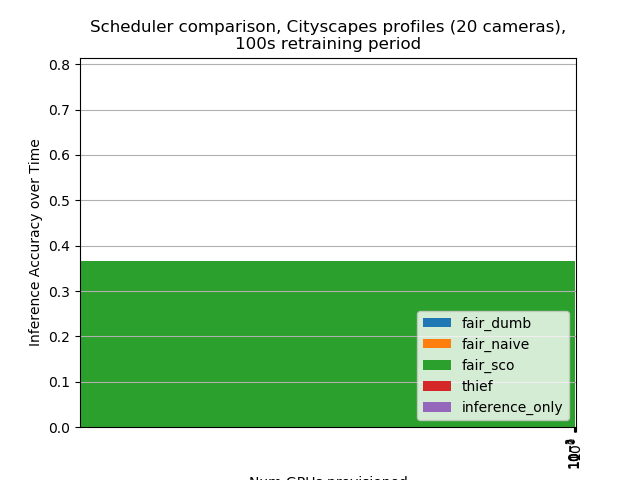

In [35]:
for PERIOD in [100]:#, 100]:#, 100, 200, 400]:
    sched_names = [sched_name for _, sched_name in schedulers_to_test if sched_name!='fair_random']
    const_res_data = df[df['period'] == PERIOD]
    ax = const_res_data.plot(x='resources', y=sched_names, kind='bar',
                        title ="Scheduler comparison, Cityscapes profiles ({} cameras),\n{}s retraining period".format(len(camera_names), PERIOD),
                        legend=True)
    ax.set_xlabel("Num GPUs provisioned")
    ax.set_ylabel("Inference Accuracy over Time")
    ax.legend(loc='lower right')
    ax.grid(axis='y')
    plt.savefig('/tmp/schedcompare_{}.pdf'.format(PERIOD))

In [35]:
#print(allocation['50_1_thief']["1"])
print(allocation['50_1_fair_sco']["1"])
#allocation['50_1_inference_only']

{0: {'zurich_train_0': 0.05, 'aachen_train_33': 0.05, 'stuttgart_train_0': 0.05, 'darmstadt_train_27': 0.05, 'dusseldorf_train_24': 0.05, 'tubingen_train_18': 0.05, 'bremen_train_20': 0.05, 'ulm_train_18': 0.05, 'cologne_train_21': 0.05, 'jena_train_33': 0.05, 'zurich_inference': 0.05, 'aachen_inference': 0.05, 'stuttgart_inference': 0.05, 'darmstadt_inference': 0.05, 'dusseldorf_inference': 0.05, 'tubingen_inference': 0.05, 'bremen_inference': 0.05, 'ulm_inference': 0.05, 'cologne_inference': 0.05, 'jena_inference': 0.05}, 11.665301322937012: {'ulm_train_18': 0, 'zurich_train_0': 0.052631578947368425, 'aachen_train_33': 0.052631578947368425, 'stuttgart_train_0': 0.052631578947368425, 'darmstadt_train_27': 0.052631578947368425, 'dusseldorf_train_24': 0.052631578947368425, 'tubingen_train_18': 0.052631578947368425, 'bremen_train_20': 0.052631578947368425, 'cologne_train_21': 0.052631578947368425, 'jena_train_33': 0.052631578947368425, 'zurich_inference': 0.052631578947368425, 'aachen_in

In [36]:
pd.DataFrame(allocation['50_1_fair_sco']["1"])

,0.0,11.665301322937012,16.06399440765381,27.941957473754883,30.0522243976593,50.50085949897766,54.90025448799133,80.0557234287262,84.54527997970581,99.77826738357544,111.8617308139801
aachen_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
aachen_train_33,0.05,0.052632,0.055556,0.058824,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
bremen_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
bremen_train_20,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.000000,0.0
cologne_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
cologne_train_21,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.0
darmstadt_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
darmstadt_train_27,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.000000,0.000000,0.0
dusseldorf_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
dusseldorf_train_24,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.000000,0.000000,0.000000,0.0


In [37]:
pd.DataFrame(allocation['50_1_thief']["1"])

,0.0,11.665301322937012,14.631958484649658,15.572422504425049,15.96550178527832,16.816251754760742,27.765329360961914,29.712453365325928,30.32125186920166,31.800294876098633,34.956321239471436
aachen_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
aachen_train_18,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.000000,0.000000,0.000000,0.000000,0.0
bremen_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
bremen_train_18,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.0
cologne_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
cologne_train_18,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.000000,0.000000,0.000000,0.0
darmstadt_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
darmstadt_train_18,0.05,0.052632,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
dusseldorf_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
dusseldorf_train_18,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.000000,0.0


### Accuracy progression

In [ ]:
plt.figure()
for job, result in results.items():
    if job != 'meta':
        t, acc = list(zip(*result))
        plt.plot(t, acc, label=job.name)
plt.title("Training and inference job accuracy over time")
plt.legend()
plt.xlabel("Wall time")
plt.ylabel("Accuracy")

In [ ]:
for t, allocation in sim.period_allocation.items():
    names = []
    allocs = []
    for j, alloc in allocation.items():
        allocs.append(alloc)
        names.append(j.name)
    print(names, allocs)
    plt.figure()
    plt.pie(allocs, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title("Allocation at t = {}".format(t))

In [ ]:
means = []
for j, result in results.items():
    if isinstance(j, InferenceJob):
        mean_accuracy = sum(r[1] for r in result)/len(result)
        means.append(mean_accuracy)
MEAN_AUC = sum(means)/len(means)
print("Mean Inference Accuracy across all jobs: {}".format(MEAN_AUC))

In [ ]:
results['meta']

# Plot Inference Profiles

In [9]:
fn, inv = get_infer_profile(max_inference_resources=0.25)

<IPython.core.display.Javascript object>


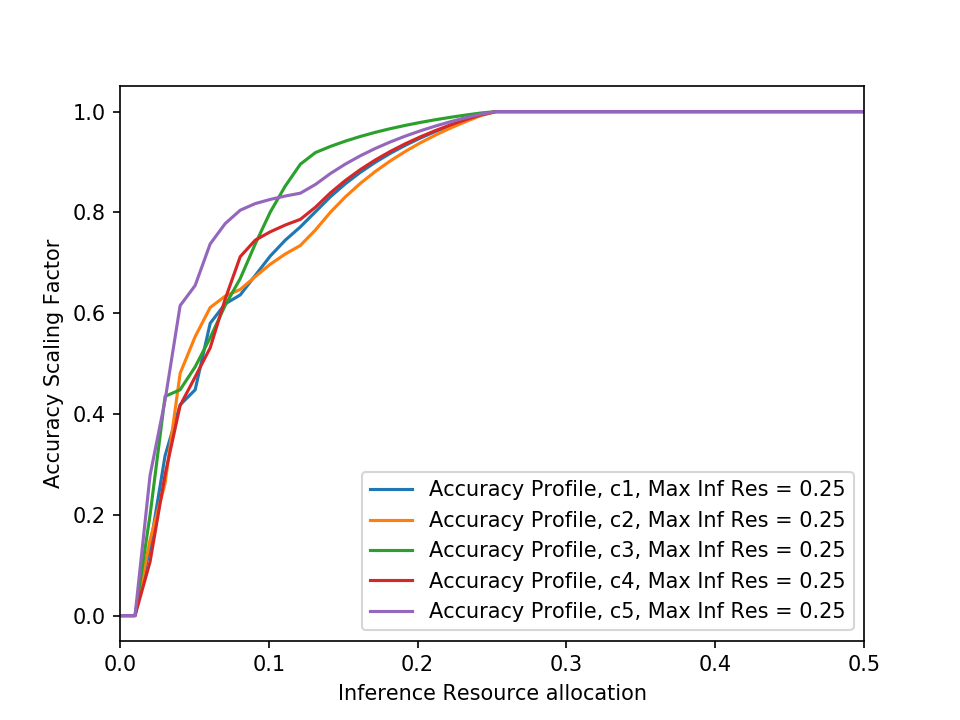

(0, 0.5)

In [15]:
for c in ["c{}".format(i) for i in range(1,6)]:
    fn, inv = get_infer_profile(max_inference_resources=0.25, camera=c)
    x = np.linspace(0,1,100) # 100 linearly spaced numbers
    y = [fn(v) for v in x]
    plt.plot(x,y, label="Accuracy Profile, {}, Max Inf Res = 0.25".format(c))
plt.legend()
plt.xlabel('Inference Resource allocation')
plt.ylabel('Accuracy Scaling Factor')
plt.xlim([0,0.5])

# Figure 7 - Single Camera

<IPython.core.display.Javascript object>


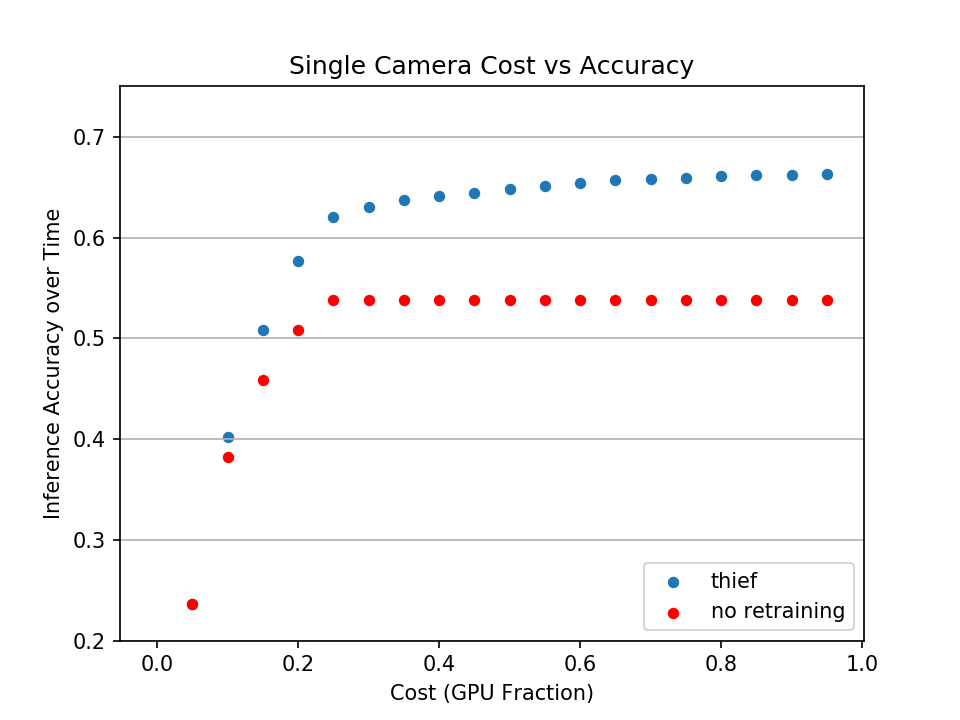

In [34]:
for PERIOD in [100]:#, 100]:#, 100, 200, 400]:
    sched_names = [sched_name for _, sched_name in schedulers_to_test if sched_name!='fair_random']
    const_res_data = df[df['period'] == PERIOD]
    ax = const_res_data.plot(x='resources', y='thief', kind='scatter', label='thief')
    
    const_res_data.plot(x='resources', y='inference_only', kind='scatter', color='red', label='no retraining', ax=ax)
    ax.set_xlabel("Cost (GPU Fraction)")
    ax.set_ylabel("Inference Accuracy over Time")
    ax.legend(loc='lower right')
    ax.grid(axis='y')
    ax.set_ylim([0.2,0.75])
    ax.set_title('Single Camera Cost vs Accuracy')
    plt.savefig('/tmp/schedcompare_{}.pdf'.format(PERIOD))